In [1]:
import os
import astropy.coordinates as astro_coord
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import quickage

%matplotlib inline

In [2]:
from astropy.io import fits
from astropy.table import Table

In [3]:
def load_galah_sharma():
    #sharma 2018 and other catalogs
    sharma_ages_hdu=fits.open('/users/caganze/GALAH_DR3_VAC_ages_v2.fits')
    sharma_meta_hdu=fits.open('/users/caganze/GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    sharma_kinem_hdu=fits.open('/users/caganze/GALAH_DR3_VAC_rv_v2.fits')
    sharma_dyn_hdu=fits.open('/users/caganze/GALAH_DR3_VAC_dynamics_v2.fits')
    
    #master file 
    #get metallicities and alpha from GALAH
    galah_master= Table(fits.open('/Volumes/LaCie/GALAH_DR3_main_allspec_v2.fits')[1].data).to_pandas()
    
    #tables
    sh_dyn_tbl=Table(sharma_dyn_hdu[1].data).to_pandas()
    sh_age_tbl=Table(sharma_ages_hdu[1].data).to_pandas()
    sh_met_tbl=Table(sharma_meta_hdu[1].data).to_pandas()
    sh_kin_tbl=Table(sharma_kinem_hdu[1].data).to_pandas()
    
    merged_master_file=sh_age_tbl.merge(sh_met_tbl,\
                                    on='sobject_id').merge(sh_kin_tbl, \
                                                           on='sobject_id').merge(sh_dyn_tbl, on='sobject_id')
    
    merged_final=   merged_master_file.merge(galah_master, on='sobject_id')
    
    #print ( merged_master_file['rv_galah'])
    #
    
    #save merged table
    merged_final.to_hdf('/Volumes/LaCie/merged_galah_dr3_sharma2018.h5', key='all')
    
    columns={'rv_galah_x' : 'rv', 
             'e_rv_galah_x': 'er_rv',
             'parallax': 'plx',
             'parallax_error': 'eplx',
             'pmdec': 'pmde',
             'J_Z': 'Jz',
             'J_R': 'Jr',
            }
    
    merged=merged_final.rename(columns=columns)
    ds=np.nanmedian(1000/np.random.normal(merged.plx, merged.eplx, size=( 1000, len(merged.eplx))), axis=0)
    #compute astropy coordinates in our coordinate frame
    Scoord={'ra': merged.ra ,\
              'dec':  merged.dec,\
              'pmra':  merged.pmra,
              'pmdec':  merged.pmde,
              'distance': np.abs(ds),
              'rv':merged['rv'].values}

    _, source_pos=quickage.get_phase_space(Scoord['ra'], 	Scoord['dec'],\
                        Scoord['pmra']*np.cos(	Scoord['dec']*u.degree), \
                        Scoord['pmdec'], 	Scoord['distance'], Scoord['rv'])
    
    merged['x']= source_pos.x.to(u.pc).value
    merged['y']= source_pos.y.to(u.pc).value
    merged['z']= source_pos.z.to(u.pc).value
    
    merged['v_x']= source_pos.v_x.to(u.km/u.s).value
    merged['v_y']= source_pos.v_y.to(u.km/u.s).value
    merged['v_z']= source_pos.v_z.to(u.km/u.s).value
    merged['v_r']= (merged.v_x**2+merged.v_y**2)**0.5
    merged['vtot']= (merged.v_x**2+merged.v_y**2+merged.v_z**2)**0.5
    merged['pmracosdec']= merged.pmra*np.cos(merged.dec*u.deg)
    #rename colunns
    #some renaming just to stick to uniform naming convention
  
    return merged[['sobject_id', 'vtot', 'x', 'y', 'z', 'v_x', 'v_y',  'v_r', 'v_z',\
        'Jz', 'ra', 'dec',  'er_rv',\
        'pmracosdec', 'e84_age_bstep', 'age_bstep',
                   'e16_age_bstep', 'eplx', 'pmde',\
        'pmra', 'plx', 'rv', 'ruwe', 
         'U_UVW', 'V_UVW', 'W_UVW', 'R_Rzphi', 'z_Rzphi', 'phi_Rzphi',\
        'Jr', 'L_Z', 'Jz',  'fe_h', 'e_fe_h', 'alpha_fe', 'e_alpha_fe', 'vT_Rzphi', \
                   'j_m', 'h_m', 'ks_m', 'abs_j_bstep', 'abs_ks_bstep']]


In [4]:
galah=load_galah_sharma()

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)



In [5]:
galah.to_csv('/users/caganze/research/quickage/data/galah_sharma.csv.gz', compression='gzip')

In [6]:
#fig, ax=plt.subplots()
#_ =ax.hist(galah['vtot'].values, bins=100, range=[0, 500])

In [7]:
galah.columns

Index(['sobject_id', 'vtot', 'x', 'y', 'z', 'v_x', 'v_y', 'v_r', 'v_z', 'Jz',
       'ra', 'dec', 'er_rv', 'pmracosdec', 'e84_age_bstep', 'age_bstep',
       'e16_age_bstep', 'eplx', 'pmde', 'pmra', 'plx', 'rv', 'ruwe', 'U_UVW',
       'V_UVW', 'W_UVW', 'R_Rzphi', 'z_Rzphi', 'phi_Rzphi', 'Jr', 'L_Z', 'Jz',
       'fe_h', 'e_fe_h', 'alpha_fe', 'e_alpha_fe', 'vT_Rzphi', 'j_m', 'h_m',
       'ks_m', 'abs_j_bstep', 'abs_ks_bstep'],
      dtype='object')

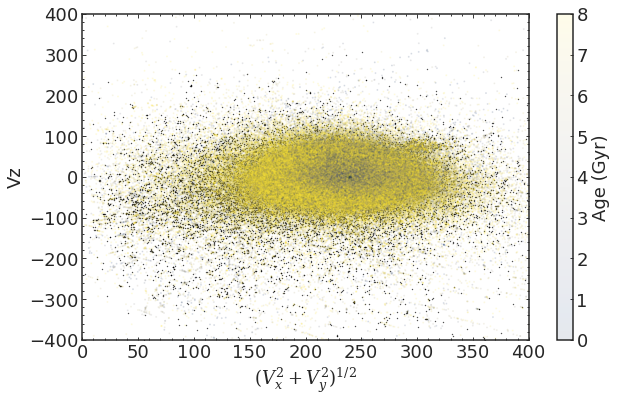

In [27]:
thindisk_select=np.logical_or(galah.age_bstep<8., galah.alpha_fe<1.)
#mask metal poor, alpha enriched stars 
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter(galah['v_r'][~thindisk_select], galah['v_z'][~thindisk_select], s=.1, c='k')

c=ax.scatter(galah['v_r'][thindisk_select], \
             galah['v_z'][thindisk_select],\
           c=galah.age_bstep[thindisk_select], s=1., vmin=0, vmax=8, cmap='cividis', alpha=0.1)
ax.set(xlim=[0, 400], ylim=[-400, 400], xlabel=r'$(V_x^2+ V_y^2)^{1/2}$', ylabel='Vz')
#o.plot(ax=ax)
cbar=plt.colorbar(c)
cbar.ax.set(ylabel='Age (Gyr)')
ax.minorticks_on()

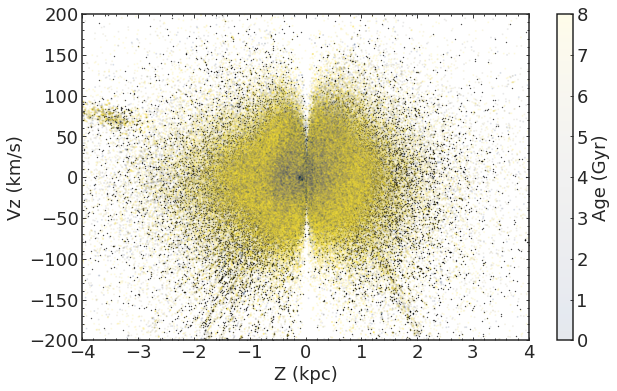

In [28]:
#mask metal poor, alpha enriched stars 
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter(galah['z'][~thindisk_select]/1000, galah['v_z'][~thindisk_select], s=.1, c='k')

c=ax.scatter(galah['z'][thindisk_select]/1000, \
             galah['v_z'][thindisk_select],\
           c=galah.age_bstep[thindisk_select], s=1., vmin=0, vmax=8, cmap='cividis', alpha=0.1)
ax.set(xlim=[-4, 4], ylim=[-200, 200], xlabel=r'Z (kpc)', ylabel='Vz (km/s)')
#o.plot(ax=ax)
cbar=plt.colorbar(c)
cbar.ax.set(ylabel='Age (Gyr)')
ax.minorticks_on()

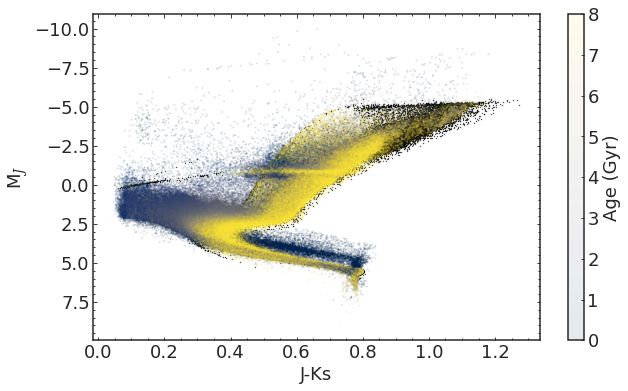

In [34]:
#mask metal poor, alpha enriched stars 
fig, ax=plt.subplots(figsize=(10, 6))
c=ax.scatter(galah['abs_j_bstep'][~thindisk_select]- galah['abs_ks_bstep'][~thindisk_select], \
             galah['abs_j_bstep'][~thindisk_select], s=.1, c='k')
c=ax.scatter(galah['abs_j_bstep'][thindisk_select]- galah['abs_ks_bstep'][thindisk_select], \
             galah['abs_j_bstep'][thindisk_select],  c=galah.age_bstep[thindisk_select],\
             s=1., vmin=0, vmax=8, cmap='cividis', alpha=0.1)


#o.plot(ax=ax)
cbar=plt.colorbar(c)
ax.invert_yaxis()
cbar.ax.set(ylabel='Age (Gyr)')

ax.set( xlabel='J-Ks', ylabel=r'M$_J$')
ax.minorticks_on()
plt.savefig('/users/caganze/desktop/galah_sharma_sample.jpeg')

In [1]:
import quickage
import warnings
warnings.filterwarnings("ignore")
#compute schneider orbits in the same reference frame as galah
old_schneider=quickage.load_schneider_samples_old(use_jz=True)
old_schneider.to_csv('/users/caganze/research/quickage/data/schneiderdata_lite.csv.gz', compression='gzip')

IsochronePotential
(300, 1434)


100%|███████████████████████████████████████| 1434/1434 [04:09<00:00,  5.74it/s]


In [2]:
len(galah)

NameError: name 'galah' is not defined